# Project 5

In [233]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing & Pipelines
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation imports
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score,
    precision_score,
    accuracy_score,
    make_scorer,
    roc_auc_score
)
# Import param_tuning, testing and evaluating
import sys
sys.path.append('D:\Courses for future\Concordia Bootcamp\Projects\Project 5')

from Testing import testing,param_tuning,evaluating,weighted_recall_precision

import category_encoders as ce
from optbinning import BinningProcess, OptimalBinning
from category_encoders.woe import WOEEncoder

import joblib

In [2]:
plt.rcParams['axes.grid'] = False
sns.set_theme(style="dark")

## Data at glance

In [5]:
risk = pd.read_csv('Loans.csv')
risk.sample(5)

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
241,242.0,26,74004,RENT,10.0,DEBTCONSOLIDATION,C,"£25,000.00",NaN,10,Y,4,DEFAULT
23788,23785.0,29,33600,RENT,0.0,PERSONAL,D,"£9,600.00",15.99,9,Y,7,DEFAULT
21247,21244.0,28,30000,RENT,2.0,PERSONAL,A,"£5,200.00",5.42,8,NaN,7,NO DEFAULT
13369,13368.0,23,90000,MORTGAGE,1.0,EDUCATION,D,"£15,000.00",16.32,3,NaN,2,NO DEFAULT
30602,30598.0,39,60000,MORTGAGE,22.0,PERSONAL,B,"£4,000.00",10.59,9,N,12,NO DEFAULT


In [6]:
risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32586 entries, 0 to 32585
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          32583 non-null  float64
 1   customer_age         32586 non-null  int64  
 2   customer_income      32586 non-null  object 
 3   home_ownership       32586 non-null  object 
 4   employment_duration  31691 non-null  float64
 5   loan_intent          32586 non-null  object 
 6   loan_grade           32586 non-null  object 
 7   loan_amnt            32585 non-null  object 
 8   loan_int_rate        29470 non-null  float64
 9   term_years           32586 non-null  int64  
 10  historical_default   11849 non-null  object 
 11  cred_hist_length     32586 non-null  int64  
 12  Current_loan_status  32582 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 3.2+ MB


In [7]:
# Check duplicates
risk.customer_id.nunique() # Contain duplicates

32577

In [8]:
# Check missing values
risk.isna().sum()[risk.isna().any()]

customer_id                3
employment_duration      895
loan_amnt                  1
loan_int_rate           3116
historical_default     20737
Current_loan_status        4
dtype: int64

Missing values in customer_id, loan_amnt, and Current_loan_status need to be dropped. The dataset needs to be deduplicated by customer_id.  
Since there are 4 instances where Current_loan_status is missing, they will be used as the final features to predict on. 

In [280]:
# Drop duplicates in customer_id
risk_1 = risk.drop_duplicates('customer_id').copy()

# Drop na in customer_id, loan_amnt
risk_1.dropna(subset=['customer_id'],inplace=True)
risk_1.dropna(subset=['loan_amnt'],inplace=True)

# Drop customer_id column
risk_1.drop(columns='customer_id',inplace=True)
risk_1.shape # Pass

# Encode Default = 1, No Default = 0
risk_1.loc[risk_1['Current_loan_status']=='DEFAULT','Current_loan_status_encoded']=1
risk_1.loc[risk_1['Current_loan_status']=='NO DEFAULT','Current_loan_status_encoded']=0

#### loan_amnt and customer_income type correction 

In [281]:
# Convert string to numeric
risk_1['loan_amnt'] = pd.to_numeric(risk_1['loan_amnt'].str.replace(',', '').str[1:])
risk_1['customer_income'] = pd.to_numeric(risk_1['customer_income'].str.replace(',',''))
risk_1[['loan_amnt','customer_income']].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,32576.0,9724.745211,21071.881794,500.0,5000.0,8000.0,12200.0,3500000.0
customer_income,32576.0,66072.987414,61987.652093,4000.0,38500.0,55000.0,79200.0,6000000.0


In [282]:
# Instances with missing value in Current_loan_status will be used by the end to predict on the target.
X_pr = risk_1[risk_1['Current_loan_status'].isna()].drop(columns=['Current_loan_status','Current_loan_status_encoded']).copy()
risk_1.drop(X_pr.index.tolist(),inplace=True) # Pass shape check
X_pr = X_pr.iloc[[0,1,3]].copy()


## EDA

In [25]:
risk_1.Current_loan_status.value_counts(normalize=True) # AR = 0.80

Current_loan_status
NO DEFAULT    0.790159
DEFAULT       0.209841
Name: proportion, dtype: float64

### Data Quality Check

#### customer_age cross check with employment_duration and cred_hist_length

In [26]:
# customer_age, employment_duration cross-validation
risk_1[['customer_age','employment_duration']].describe().T

# There are some issues related to age min==3, max==144, 
# and employment_duration, max==123

,count,mean,std,min,25%,50%,75%,max
customer_age,32558.0,27.710517,6.176049,20.0,23.0,26.0,30.0,78.0
employment_duration,31663.0,4.782048,4.035543,0.0,2.0,4.0,7.0,41.0


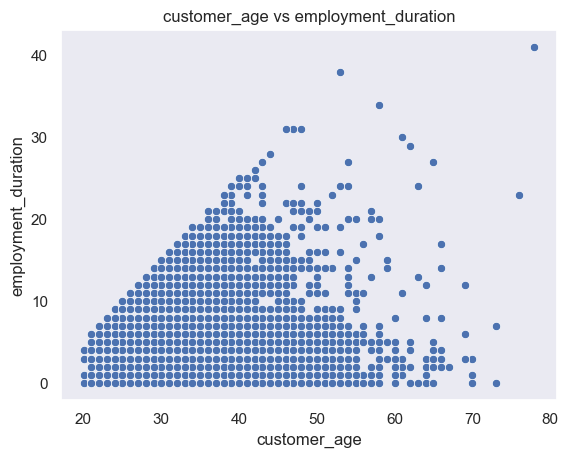

In [27]:
# Visualization to help choose the cut-off
fig1,ax1=plt.subplots()
sns.scatterplot(x=risk_1['customer_age'],y=risk_1['employment_duration'],ax=ax1)
ax1.set_title('customer_age vs employment_duration');

To drop as these data looks like invalid:
1. Either the age is way too small and they have worked way too long, 
2. Or the age is way too big, and they worked way too short 


Note that for index = 32427, 32421, 32511 and 32585, those entries look more valid comparing with the others, especially loan_intent is medical for three of them, buut it is only 4 inputs which means there cases are rare/outliers. 

Since in loan_amnt, the currency is British pound (£), according to the British law, the minimum working age is 13 with restrictions, and the retirement age is 66 before 2026. Therefore, those who started working before 13 will be considered as invalid entry and will be dropped since the number of instances is small.

In [28]:
# customer_age<18 or customer_age>80
(risk_1[(risk_1['customer_age']<18) | (risk_1['customer_age']>=80)])
drop_index = (risk_1[(risk_1['customer_age']<18) | (risk_1['customer_age']>=80)].index).tolist() 

# Cross vailidate customer_age with employment_duration
risk_1[(risk_1.customer_age - risk_1.employment_duration)<13] # To drop 
drop_index += (risk_1[(risk_1.customer_age - risk_1.employment_duration)<13]).index.tolist()
len(drop_index)

0

In [29]:
# Dropping
# a. customer_age > 80
# b. customer_age < 18
# c. customer_age - employment_duration <13
len(set(drop_index)) #14
risk_1.drop(set(drop_index),inplace=True)
(risk_1.shape[0] + 14) == 32572 # Pass

True

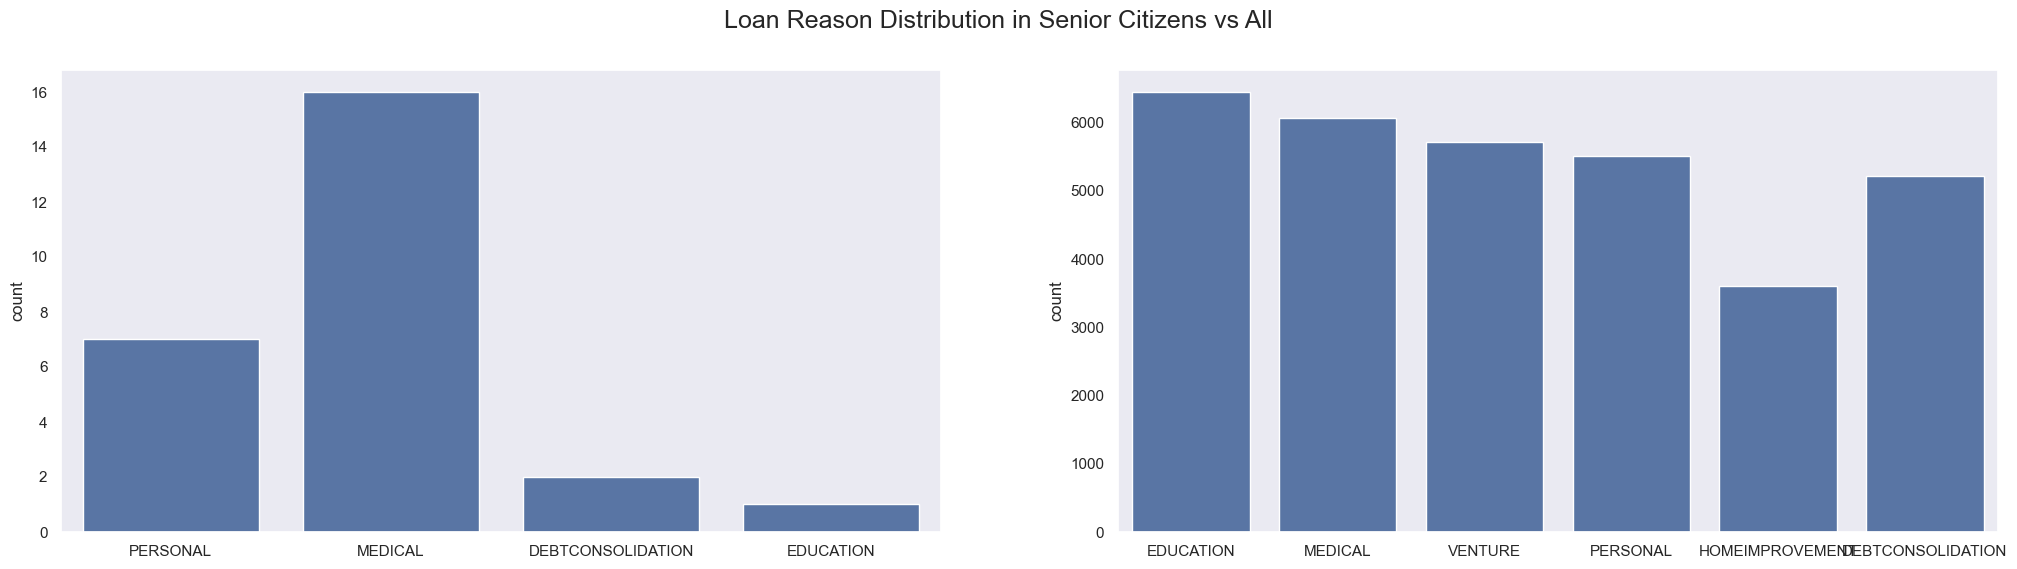

In [30]:
# Visualization, Loan purpose of senior citizens
senior = risk_1[risk_1['customer_age']>=66].copy()

fig2,(ax2,ax3)=plt.subplots(ncols=2,figsize=(25,6))
sns.countplot(data=senior, x='loan_intent',ax=ax2)
ax2.set_xlabel('')

sns.countplot(data=risk_1, x='loan_intent',ax=ax3)
ax3.set_xlabel('')
fig2.suptitle('Loan Reason Distribution in Senior Citizens vs All',fontsize=18);

It shows that for senior citizens, the most popular loan_intent medical, which is close to real life. 

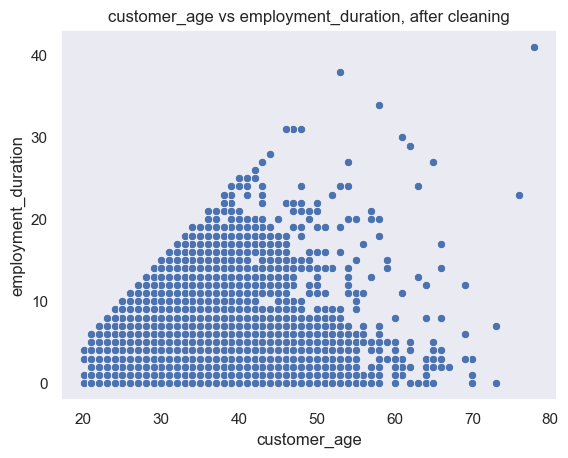

In [31]:
# Visualization after cleaning
fig4,ax4=plt.subplots()
sns.scatterplot(x=risk_1['customer_age'],y=risk_1['employment_duration'],ax=ax4)
ax4.set_title('customer_age vs employment_duration, after cleaning');

In [32]:
# Cross vailidate customer_age with cred_hist_length
risk_1[(risk_1.customer_age - risk_1.cred_hist_length)<17] # 5 instances

,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status,Current_loan_status_encoded
1315,20,64000,RENT,3.0,VENTURE,C,"£16,000.00",15.31,8,Y,4,DEFAULT,1.0
3853,20,32652,MORTGAGE,0.0,PERSONAL,C,"£6,000.00",14.61,2,N,4,DEFAULT,1.0
13920,20,98000,MORTGAGE,4.0,EDUCATION,C,"£24,250.00",NaN,2,NaN,4,NO DEFAULT,0.0
15834,20,188004,MORTGAGE,4.0,EDUCATION,A,"£2,000.00",8.59,2,NaN,4,NO DEFAULT,0.0
17200,20,65000,MORTGAGE,4.0,VENTURE,A,"£4,800.00",9.99,2,NaN,4,NO DEFAULT,0.0


Since in UK, the minimum age to apply for a credit card is 18. Here 17 is choosed to avoid rounding errors. However, there are possible other ways to build credit history when an applicant is below 18. Therefore, these data are not considered as invalid. 

### Missing Data

In [34]:
risk_1.isna().sum()[risk_1.isna().any()]

employment_duration      895
loan_int_rate           3111
historical_default     20728
dtype: int64

#### historical_default
There are various reasons that can explain why over 20k entries have historical_default missing. One of them can be, the customer does not have any other loans prior to this loan and therefore the data is missing. However, after investigating deeper into the data, it is easy to notices that for certain customers with home_ownership of Mortgage, they also have a missing value in historical_default. It is also noticeable that among those non-missing entries, over half of the customers has a historical_default. This proportion does not align with the proportion of Current_loan_status. By replacing missing values with N, the proportion of Non-Default would increase to around 0.81 which aligns with the proportion of Current_loan_status. Therefore, here a bold imputations is performed: missing values in historical_default will be replaced by N. 

In [36]:
# historical default
risk_1.historical_default.value_counts(normalize=True).reset_index() # 0.48 N
sum_before = (risk_1.groupby('historical_default',as_index=False)['Current_loan_status'].value_counts(normalize=True))
risk_1.fillna({'historical_default':'N'},inplace=True) # Replace with N
risk_1.historical_default.value_counts(normalize=True).reset_index() # N = 0.81, current_N = 0.79
sum_after = (risk_1.groupby('historical_default',as_index=False)['Current_loan_status'].value_counts(normalize=True))


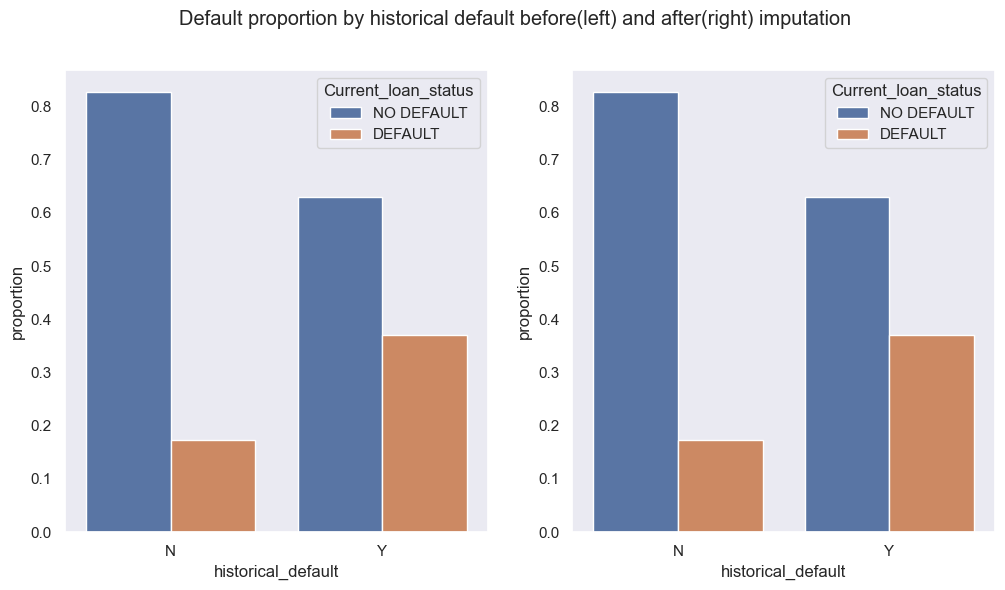

In [37]:
# Visualization, before imputation vs after imputation
fig5,(ax5,ax6) = plt.subplots(ncols=2, figsize=(12,6))
sns.barplot(data=sum_before.sort_values(by=['historical_default','Current_loan_status'],ascending=[True,False]), 
            x='historical_default', y='proportion', hue='Current_loan_status',ax=ax5)

sns.barplot(data=sum_after, 
            x='historical_default', y='proportion', hue='Current_loan_status',ax=ax6)
plt.suptitle('Default proportion by historical default before(left) and after(right) imputation');

### loan_int_rate
Although the missing value in loan_int_rate can be imputed with median or mean, the WOE method would be used to encode all the features. Therefore, the missing values in loan_int_rate will not be filled. 
WOE encoder was applied to encode loan_int_rate, therefore, the missing value will not be filled.

However, the risk_nna dataframe is established to show the correlation between the features and variables. 

In [38]:
risk_1.loan_int_rate.isna().sum() # Around 10% Missing

3111

In [39]:
risk_1[['loan_int_rate','customer_income','loan_amnt','term_years']].corr() # No correlation
risk_1[['loan_int_rate']].describe().T
# Missing value in loan_int_rate will be replaced by mean -> mean / median are almost the same

,count,mean,std,min,25%,50%,75%,max
loan_int_rate,29447.0,11.011873,3.240724,5.42,7.9,10.99,13.47,23.22


In [45]:
risk_nna = risk_1.copy()
risk_nna['loan_int_rate']=risk_nna['loan_int_rate'].fillna(risk_1['loan_int_rate'].mean())

### employement_duration
With 3% missing value in employment rate, below are the four possible solutions:
1. Drop all missing instances
2. Simply impute it by mean/median
3. Cluster then impute by cluster mean/create a model to impute the missing value
4. Use Weight of Evidence encoder to put numeric data into categories, and have a missing category.

Here the first method will be used first as it is the most straightforward, but the last method will also be applied to compare by the end.

In [40]:
risk_1.employment_duration.isna().sum() # Around 3%
risk_1[['employment_duration']].describe().T

,count,mean,std,min,25%,50%,75%,max
employment_duration,31663.0,4.782048,4.035543,0.0,2.0,4.0,7.0,41.0


In [41]:
risk_1[['employment_duration','cred_hist_length','customer_age','customer_income']].corr()
# A model can be made based on customer_age, and customer_income to fill in na

,employment_duration,cred_hist_length,customer_age,customer_income
employment_duration,1.000000,0.149910,0.173884,0.154782
cred_hist_length,0.149910,1.000000,0.878305,0.123571
customer_age,0.173884,0.878305,1.000000,0.141505
customer_income,0.154782,0.123571,0.141505,1.000000


In [48]:
# Drop na
risk_nna = risk_nna.dropna(subset=['employment_duration'])
risk_nna.isna().sum() # Pass no missing values

risk_nna.reset_index(inplace=True)

## Univariate Analysis

In [51]:
target = ['Current_loan_status_encoded']
cat_col = ['home_ownership','loan_intent', 'loan_grade','historical_default']
num_col = ['customer_age','customer_income','employment_duration','loan_amnt','loan_int_rate','term_years','cred_hist_length']

For numeric columns, gini coefficient instead of pearson correlation will be calculated to compare the correlation between the feature and the target. 

In [50]:
target_df = risk_nna['Current_loan_status']
gini = []
name = []
for columns in num_col:
    feature = risk_nna[f'{columns}']
    auc = roc_auc_score(target_df, feature)
    gini_coefficient = 2 * auc - 1# Conversion from auc to gini
    name.append(f'{columns}')
    gini.append(gini_coefficient)
corr_gini_df = pd.DataFrame({'name':name, 'gini':gini} )

corr_gini_df.sort_values(by = 'gini', ascending=False)

,name,gini
1,customer_income,0.365103
2,employment_duration,0.140473
0,customer_age,0.047529
6,cred_hist_length,0.034789
5,term_years,-0.040078
3,loan_amnt,-0.118115
4,loan_int_rate,-0.432170


Note that loan_int_rate seem to have the highest correlation with the target, however, this is also a variable that is moderately imputed (10% data are missing). Therefore, it is important to check if its original pattern is disturbed by this imputation. 

<AxesSubplot:xlabel='loan_int_rate', ylabel='Percent'>

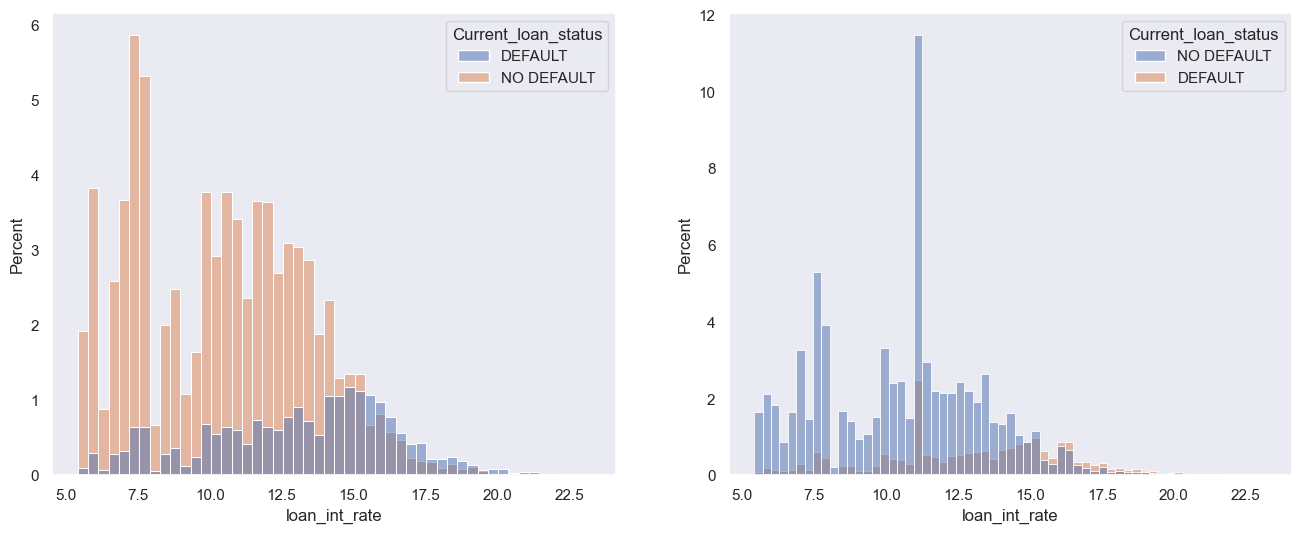

In [34]:
figd, (axd,axe) = plt.subplots(ncols=2,figsize=(16,6))
sns.histplot(data=risk, x='loan_int_rate', hue='Current_loan_status',stat='percent',ax=axd)
sns.histplot(data=risk_nna, x='loan_int_rate', hue='Current_loan_status',stat='percent',ax=axe)

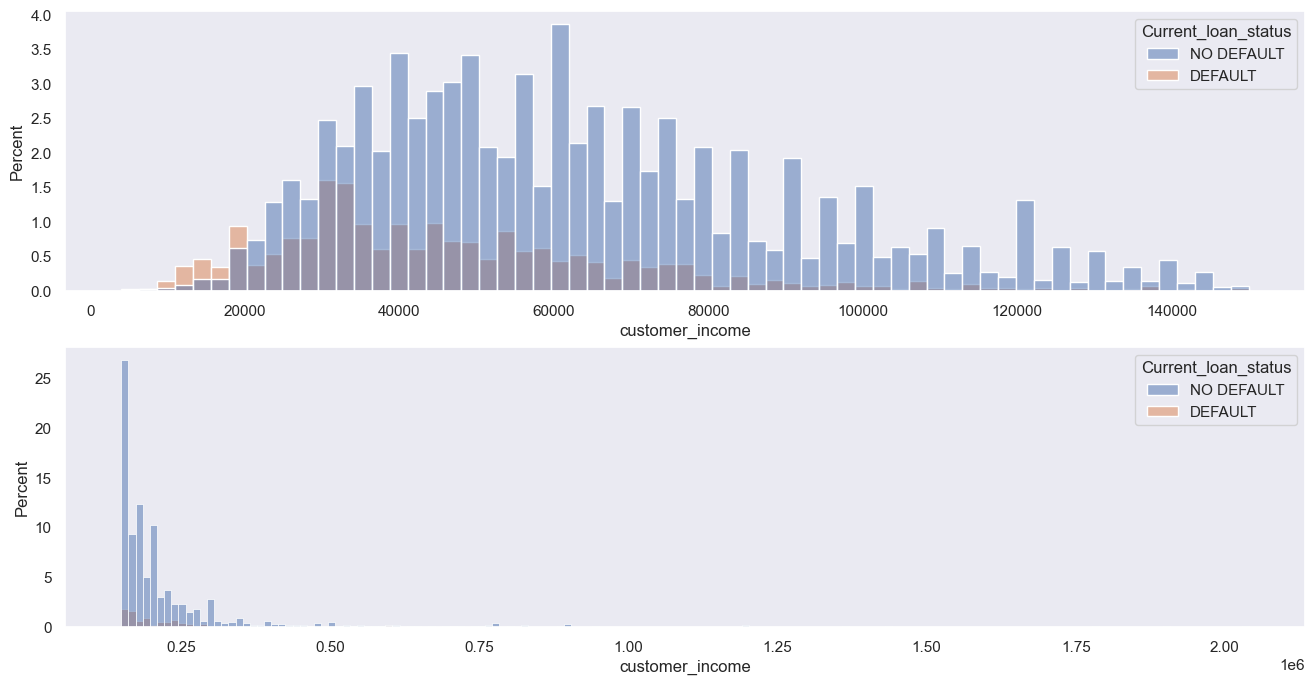

In [35]:
figg, (axg,axh) = plt.subplots(nrows=2, figsize=(16,8))
sns.histplot(data=risk_nna[risk_nna['customer_income']<150000], x='customer_income', hue='Current_loan_status',stat='percent',ax=axg)
sns.histplot(data=risk_nna[risk_nna['customer_income']>=150000], x='customer_income', hue='Current_loan_status',stat='percent',ax=axh)
plt.grid(False)

Customer income, loan amount, loan interst rate and employment duration are the four leading predictors for the target. 

In [36]:
def cat_visual(df, col, ax):
    '''
    This function aims to visualize the proportion of Default vs No Default in different categories of a chosen column

    :param [df]: dataframe of interest
    :type [df]: pd.DataFrame

    :param [col]: columnn name of interest
    :type [col]: str

    :param [ax]: the axis to be plotted on
    :type [ax]: matplotlib.axe.Axes
    ...
    :return: the summary of Churn proportion grouped by selected column
    :rtype: pd.DataFrame
    
    '''
    summary = (df.groupby(col,as_index=False)['Current_loan_status'].value_counts(normalize=True))

    sns.barplot(data=summary, x=col, y='proportion', hue='Current_loan_status',ax=ax)
    ax.set_title(f'Current Loan Status Percentage by {col}')
    ax.set_ylabel('Proportion')

    return summary

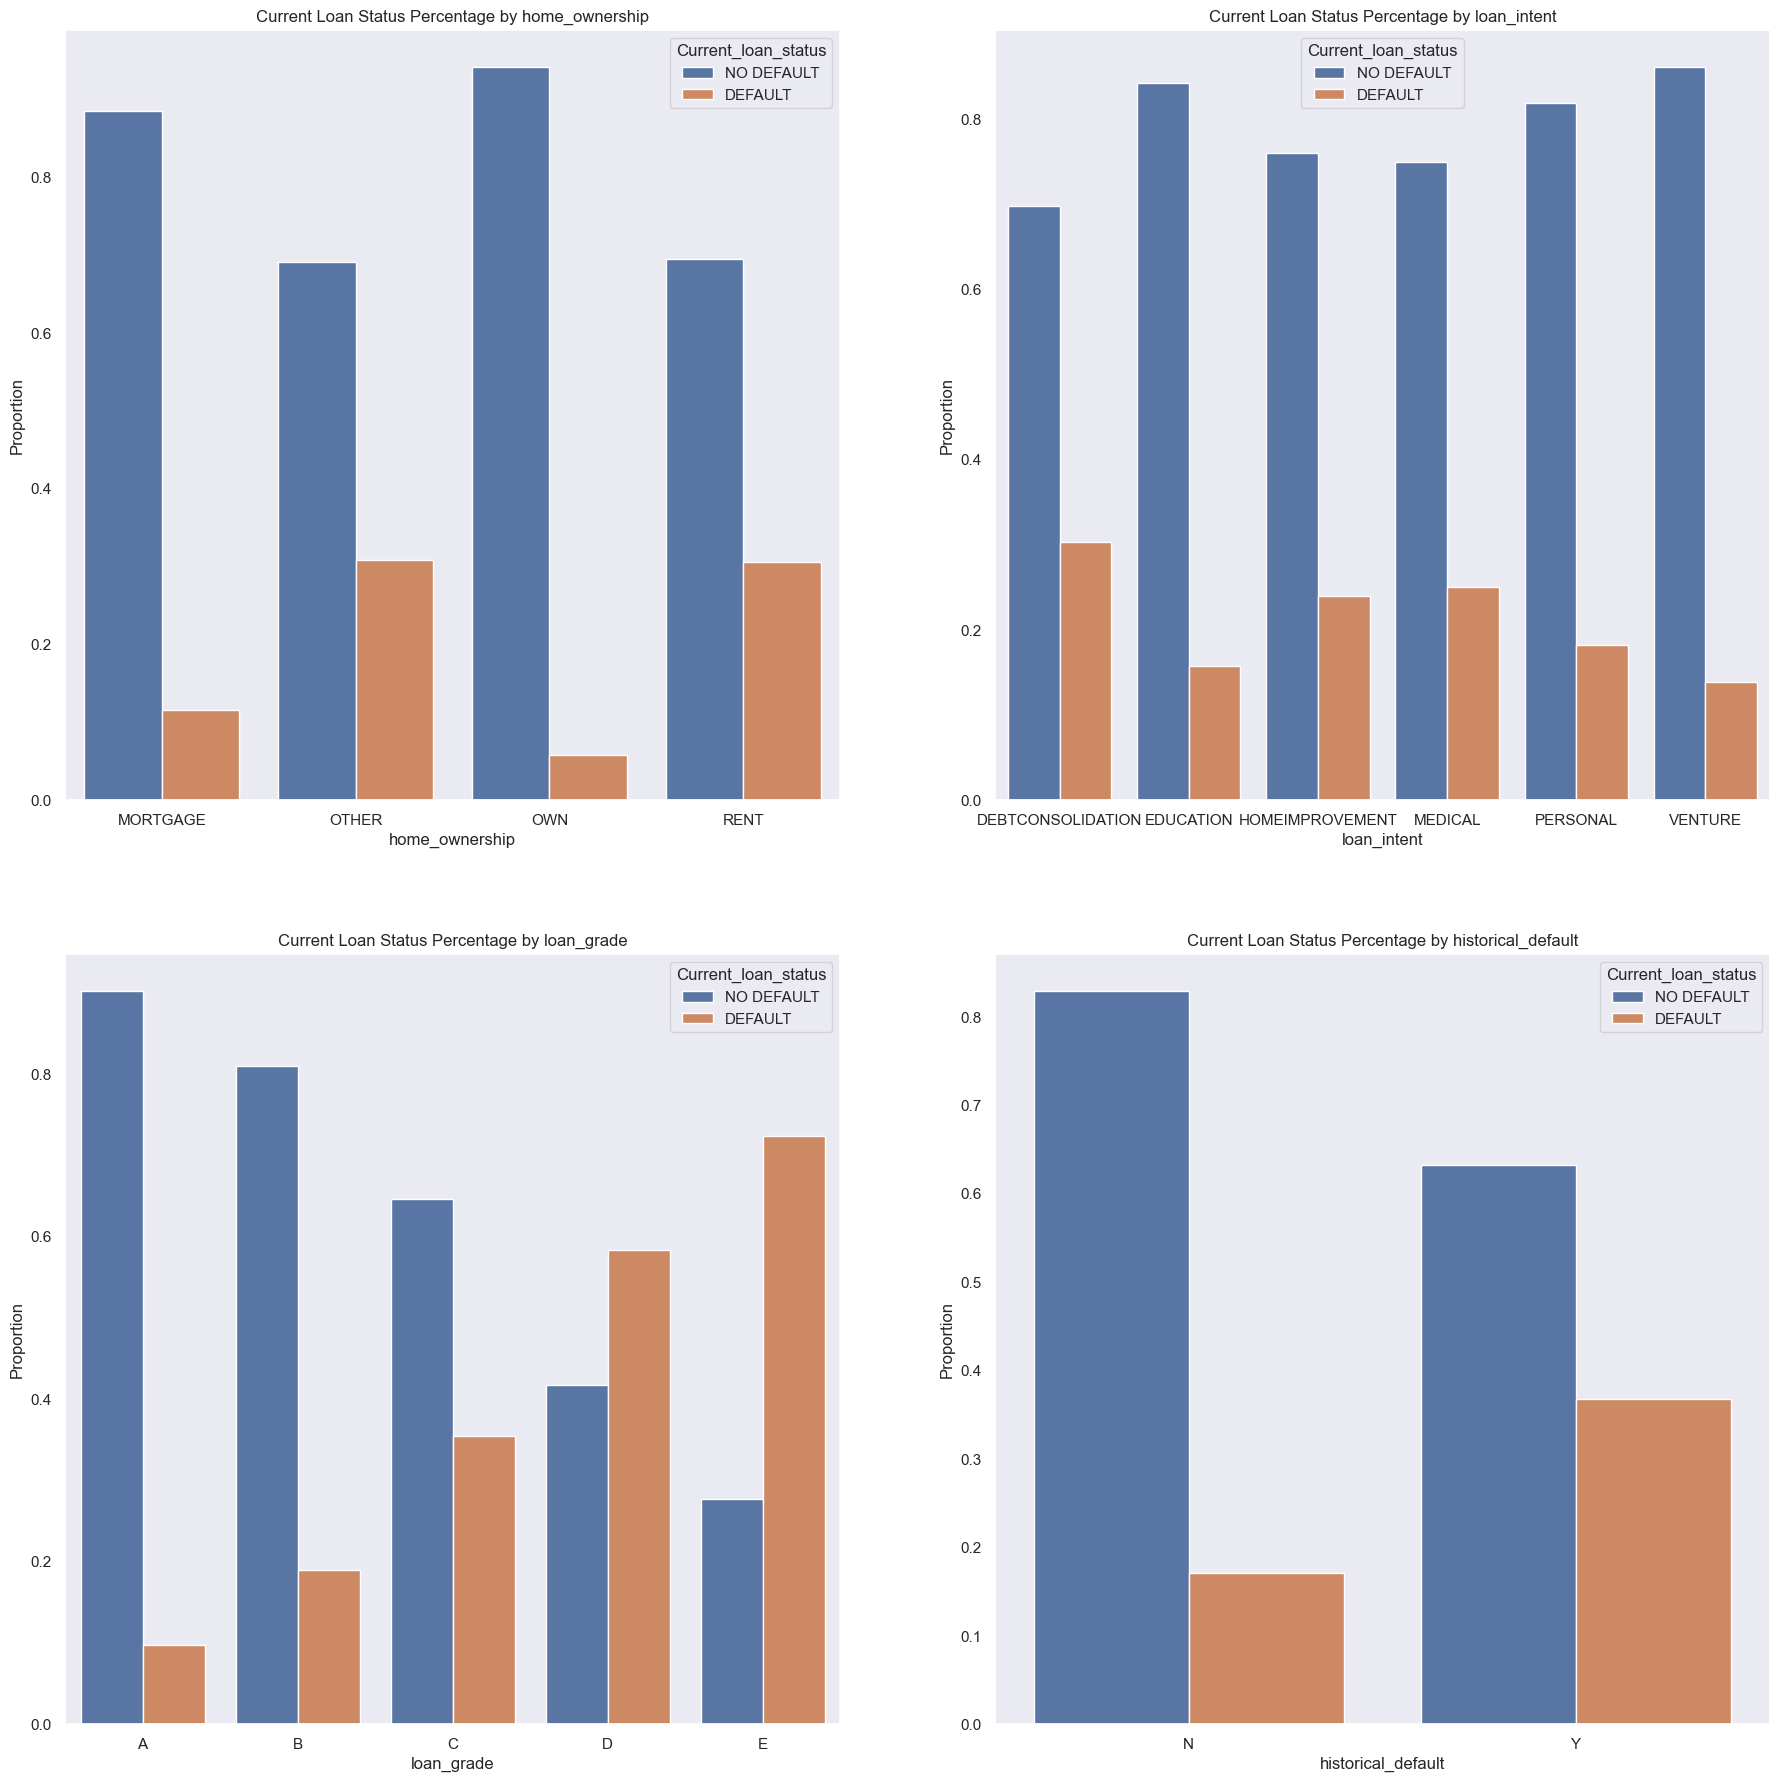

In [37]:
# Visualization
# Excuse me for the bad viz here, partially because of the long name of debt intent
# To fix this, loan intent can be coded with letters for example, and creation of another dataset to be able to refer back the loan intent is needed.
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22,22))

# Flatten the array of axes
ax1a, ax2a, ax3a, ax4a = axs.flatten()

sum_1 = cat_visual(risk_nna,'home_ownership',ax=ax1a)
sum_2 = cat_visual(risk_nna,'loan_intent',ax=ax2a)
sum_3 = cat_visual(risk_nna,'loan_grade',ax=ax3a)
sum_4 = cat_visual(risk_nna,'historical_default',ax=ax4a)

## WOE encoding

In [ ]:
target = ['Current_loan_status_encoded']
cat_col = ['home_ownership','loan_intent', 'loan_grade','historical_default']
num_col = ['customer_age','customer_income','employment_duration','loan_amnt','loan_int_rate','term_years','cred_hist_length']

In [53]:
# Train test split before WOE encoding

# With No missing value
# Recall, loan_int_rate was imputed by median
# employment_duration was dropped
# Will be handled using WOE
X_nna = risk_nna[cat_col+num_col]
y_nna = risk_nna[target[0]]
X_train_nna, X_test_nna, y_train_nna, y_test_nna = train_test_split(X_nna, y_nna, test_size=0.1, 
                                                                    stratify=risk_nna['loan_intent'], 
                                                                    random_state=5000, shuffle=True)


# With missing values
# Will be handled using OHE
X_na = risk_1[cat_col+num_col]
y_na = risk_1[target[0]]
X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(X_na, y_na, test_size=0.1, 
                                                                    stratify=risk_1['loan_intent'], 
                                                                    random_state=5000, shuffle=True)

In [55]:
woe_table_na = {}
for col in num_col:
    optb = OptimalBinning(name=col,dtype='numerical')
    optb.fit(X_train_na[col], y_train_na)
    X_train_na[f'{col}_woe'] =  optb.transform(X_train_na[col], metric="woe")
    X_test_na[f'{col}_woe'] = optb.transform(X_test_na[col])
    woe_table_na[col] = optb.binning_table


for col in cat_col:
    optb = OptimalBinning(name=col,dtype='categorical')
    optb.fit(X_train_na[col], y_train_na)
    X_train_na[f'{col}_woe'] =  optb.transform(X_train_na[col], metric="woe")
    X_test_na[f'{col}_woe'] = optb.transform(X_test_na[col])
    woe_table_na[col] = optb.binning_table


In [57]:
# Pull WOE table Example
woe_table_na['loan_int_rate'].build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.10)",1610,0.054945,1508,102,0.063354,1.362785,0.065974,0.007663
1,"[6.10, 7.46)",2535,0.086513,2322,213,0.084024,1.05811,0.069211,0.008269
2,"[7.46, 8.03)",3010,0.102723,2700,310,0.102990,0.833653,0.054923,0.006673
3,"[8.03, 9.64)",2202,0.075148,1934,268,0.121708,0.645577,0.025623,0.003148
4,"[9.64, 11.27)",4762,0.162515,4059,703,0.147627,0.422553,0.025503,0.003164
5,"[11.27, 12.07)",2368,0.080814,1991,377,0.159206,0.333365,0.008118,0.001010
6,"[12.07, 12.72)",1649,0.056276,1346,303,0.183748,0.160378,0.001380,0.000172
7,"[12.72, 13.61)",2587,0.088287,2038,549,0.212215,-0.019156,0.000033,0.000004
8,"[13.61, 14.37)",1508,0.051464,1089,419,0.277851,-0.375637,0.008047,0.001000
9,"[14.37, 15.28)",1576,0.053785,863,713,0.452411,-1.139848,0.090245,0.010707


In [68]:
# Establish WOE dataframe
X_train_woe = X_train_na.drop(columns=cat_col+num_col).copy()
X_test_woe = X_test_na.drop(columns=cat_col+num_col).copy()
X_train_woe.sample(5)

,customer_age_woe,customer_income_woe,employment_duration_woe,loan_amnt_woe,loan_int_rate_woe,term_years_woe,cred_hist_length_woe,home_ownership_woe,loan_intent_woe,loan_grade_woe,historical_default_woe
7724,-0.220928,-0.802463,0.059491,0.339456,0.333365,-0.175991,-0.094206,-0.523539,0.497521,0.882045,0.239359
28089,0.042663,-0.299071,-0.326614,0.114179,0.422553,0.124520,0.046302,0.701188,0.332120,0.106437,0.239359
10026,0.013556,0.413595,-0.238719,0.114179,0.422553,0.124520,-0.028593,0.701188,-0.224340,0.882045,0.239359
9261,-0.220928,-0.802463,-0.238719,0.211517,0.645577,-0.032803,-0.028593,-0.523539,0.149587,0.882045,0.239359
15364,0.013556,0.079194,0.177215,-0.260599,-1.764208,0.124520,-0.094206,-0.523539,-0.493216,-0.755771,0.239359


## Baseline Model 
Use loan_grade, loan_int_rate, customer_income

In [108]:
# Define numeric & categorical col
# not woe encoded
numeric_col_nna_bsl = ['customer_income','loan_int_rate']
categorical_col_nna_bsl = ['loan_grade']

X_train_nna_bsl = X_train_nna[categorical_col_nna_bsl+numeric_col_nna_bsl]
X_test_nna_bsl = X_test_nna[categorical_col_nna_bsl+numeric_col_nna_bsl]
# woe encoded
numeric_col_woe_bsl = ['loan_grade_woe','customer_income_woe','loan_int_rate_woe']
categorical_col_woe_bsl = []

X_train_woe_bsl = X_train_woe[categorical_col_woe_bsl+numeric_col_woe_bsl]
X_test_woe_bsl = X_test_woe[categorical_col_woe_bsl+numeric_col_woe_bsl]

### Logistic Regression

In [109]:
# Define grid search parameters
# With no missing
param_grid_lgr= {
    'classifier__class_weight':['balanced',None],
    'classifier__C':[0.1, 0.01, 1,0.001,10],
}

# Tuning
preprocessor_lgr_nna_bsl = param_tuning(X_train_nna_bsl,y_train_nna, LogisticRegression(),param_grid_lgr,cat_col=categorical_col_nna_bsl,num_col=numeric_col_nna_bsl)

# With WOE
# Tuning
preprocessor_lgr_woe_bsl = param_tuning(X_train_woe_bsl,y_train_na, LogisticRegression(),param_grid_lgr,cat_col=categorical_col_woe_bsl,num_col=numeric_col_woe_bsl)

Best parameters found:  {'classifier__C': 0.01, 'classifier__class_weight': None}
Best parameters found:  {'classifier__C': 0.01, 'classifier__class_weight': None}


In [110]:
# Training & testing

# With no missing
model_lgr_nna_bsl = LogisticRegression(
                        C=0.01, 
                        class_weight = None,
                                        )
y_pred_lgr_nna_bsl = testing(X_train_nna_bsl,y_train_nna, X_test_nna_bsl,y_test_nna, model=model_lgr_nna_bsl, preprocessor=preprocessor_lgr_nna_bsl)

# With WOE
model_lgr_woe_bsl = LogisticRegression(
                        C=0.01, 
                        class_weight = None,
                                        )
y_pred_lgr_woe_bsl = testing(X_train_woe_bsl,y_train_na, X_test_woe_bsl,y_test_na, model=model_lgr_woe_bsl, preprocessor=preprocessor_lgr_woe_bsl)

Baseline Logistic Regression Model Evaluation


<Figure size 800x600 with 0 Axes>

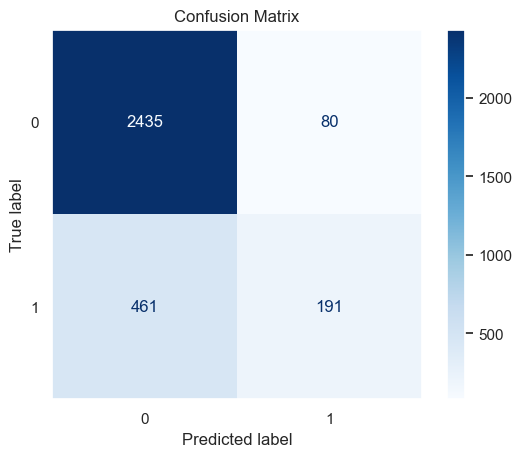

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90      2515
         1.0       0.70      0.29      0.41       652

    accuracy                           0.83      3167
   macro avg       0.77      0.63      0.66      3167
weighted avg       0.81      0.83      0.80      3167

******************************************************************************************************************************************************
Baseline Logistic Regression Model bsl Evaluation, woe


<Figure size 800x600 with 0 Axes>

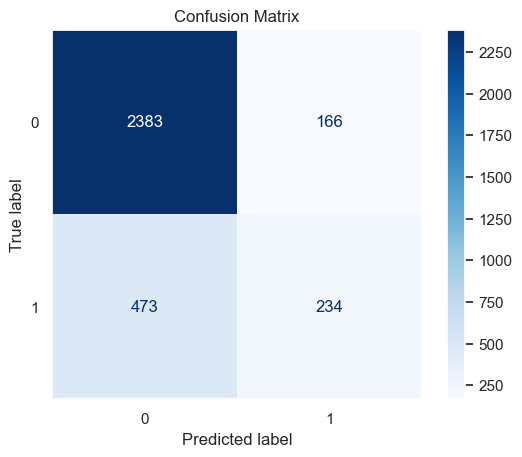

              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88      2549
         1.0       0.58      0.33      0.42       707

    accuracy                           0.80      3256
   macro avg       0.71      0.63      0.65      3256
weighted avg       0.78      0.80      0.78      3256



In [111]:
# Evaluating - worse
print('Baseline Logistic Regression Model Evaluation')
evaluating(y_pred_lgr_nna_bsl,y_test_nna) 


print('*'*150)
print('Baseline Logistic Regression Model bsl Evaluation, woe')
evaluating(y_pred_lgr_woe_bsl,y_test_na) 

### Random Forest

In [112]:
# Define grid search parameters
# With no missing
param_grid_rmf = {
    'classifier__n_estimators':[50,100,150,200],
    'classifier__max_features':[None,'sqrt'],
}

# Tuning
preprocessor_rmf_nna_bsl = param_tuning(X_train_nna_bsl,y_train_nna, RandomForestClassifier(),param_grid_rmf,cat_col=categorical_col_nna_bsl,num_col=numeric_col_nna_bsl)

# With WOE
# Tuning
preprocessor_rmf_woe_bsl = param_tuning(X_train_woe_bsl,y_train_na, RandomForestClassifier(),param_grid_rmf,cat_col=categorical_col_woe_bsl,num_col=numeric_col_woe_bsl)

Best parameters found:  {'classifier__max_features': None, 'classifier__n_estimators': 150}
Best parameters found:  {'classifier__max_features': None, 'classifier__n_estimators': 150}


In [115]:
# Training & testing
# With no missing
model_rmf_nna_bsl = RandomForestClassifier(
                        max_features=None, 
                        n_estimators = 150,
                                        )
y_pred_rmf_nna_bsl = testing(X_train_nna_bsl,y_train_nna, X_test_nna_bsl,y_test_nna, model=model_rmf_nna_bsl, preprocessor=preprocessor_rmf_nna_bsl)

# With WOE
model_rmf_woe_bsl = RandomForestClassifier(
                        max_features=None, 
                        n_estimators = 150,
                                        )
y_pred_rmf_woe_bsl = testing(X_train_woe_bsl,y_train_na, X_test_woe_bsl,y_test_na, model=model_rmf_woe_bsl, preprocessor=preprocessor_rmf_woe_bsl)

Logistic Regression Model bsl Evaluation


<Figure size 800x600 with 0 Axes>

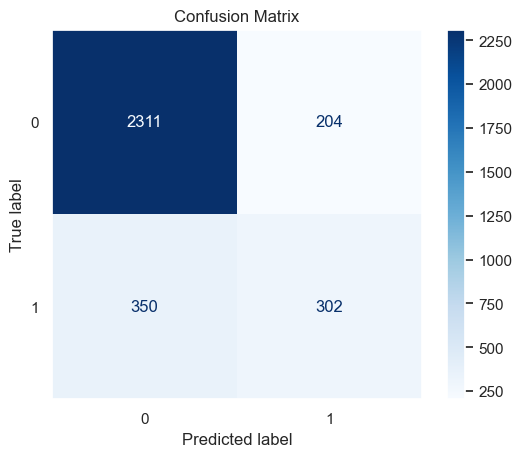

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      2515
         1.0       0.60      0.46      0.52       652

    accuracy                           0.83      3167
   macro avg       0.73      0.69      0.71      3167
weighted avg       0.81      0.83      0.82      3167

******************************************************************************************************************************************************
Logistic Regression Model bsl Evaluation, woe


<Figure size 800x600 with 0 Axes>

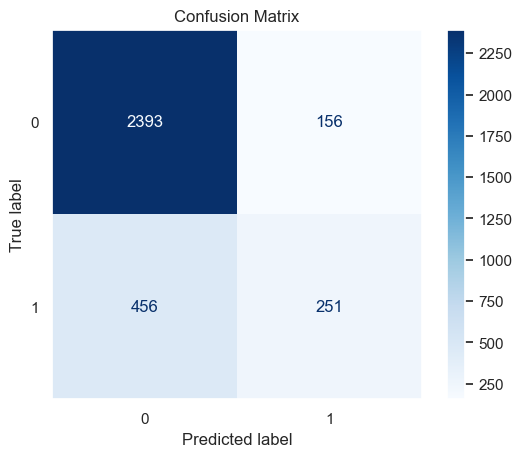

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      2549
         1.0       0.62      0.36      0.45       707

    accuracy                           0.81      3256
   macro avg       0.73      0.65      0.67      3256
weighted avg       0.79      0.81      0.79      3256



In [116]:
# Evaluating
print('Logistic Regression Model bsl Evaluation')
evaluating(y_pred_rmf_nna_bsl,y_test_nna) 


print('*'*150)
print('Logistic Regression Model bsl Evaluation, woe')
evaluating(y_pred_rmf_woe_bsl,y_test_na) 

### KNN

In [117]:
# Define grid search parameters 6mins
param_grid_knn = {
    'classifier__n_neighbors':[5,15,20,30,50],
    'classifier__weights':['uniform','distance'],
}
# Tuning
preprocessor_knn_nna_bsl = param_tuning(X_train_nna_bsl,y_train_nna, KNeighborsClassifier(),param_grid_knn,cat_col=categorical_col_nna_bsl,num_col=numeric_col_nna_bsl)

# With WOE
# Tuning
preprocessor_knn_woe_bsl = param_tuning(X_train_woe_bsl,y_train_na, KNeighborsClassifier(),param_grid_knn,cat_col=categorical_col_woe_bsl,num_col=numeric_col_woe_bsl)

Best parameters found:  {'classifier__n_neighbors': 50, 'classifier__weights': 'distance'}
Best parameters found:  {'classifier__n_neighbors': 50, 'classifier__weights': 'uniform'}


In [118]:
# Training & testing
# With no missing
model_knn_nna_bsl = KNeighborsClassifier(
                        n_neighbors=50, 
                        weights = 'distance',
                                        )
y_pred_knn_nna_bsl = testing(X_train_nna_bsl,y_train_nna, X_test_nna_bsl,y_test_nna, model=model_knn_nna_bsl, preprocessor=preprocessor_knn_nna_bsl)

# With WOE
model_knn_woe_bsl = KNeighborsClassifier(
                        n_neighbors=50, 
                        weights = 'uniform',
                                        )
y_pred_knn_woe_bsl = testing(X_train_woe_bsl,y_train_na, X_test_woe_bsl,y_test_na, model=model_knn_woe_bsl, preprocessor=preprocessor_knn_woe_bsl)

Logistic Regression Model bsl Evaluation


<Figure size 800x600 with 0 Axes>

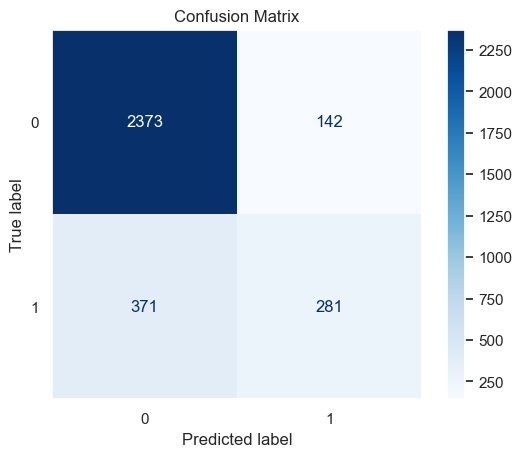

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      2515
         1.0       0.66      0.43      0.52       652

    accuracy                           0.84      3167
   macro avg       0.76      0.69      0.71      3167
weighted avg       0.82      0.84      0.82      3167

******************************************************************************************************************************************************
Logistic Regression Model bsl Evaluation, woe


<Figure size 800x600 with 0 Axes>

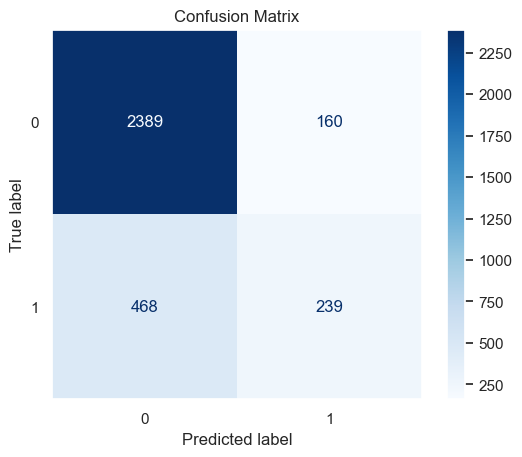

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88      2549
         1.0       0.60      0.34      0.43       707

    accuracy                           0.81      3256
   macro avg       0.72      0.64      0.66      3256
weighted avg       0.78      0.81      0.79      3256



In [119]:
# Evaluating - worse
print('Logistic Regression Model bsl Evaluation')
evaluating(y_pred_knn_nna_bsl,y_test_nna) 


print('*'*150)
print('Logistic Regression Model bsl Evaluation, woe')
evaluating(y_pred_knn_woe_bsl,y_test_na) 

HUMMMMMM, seems like incoprating the missing value increase the difficulty to predict the target using WOE. Imputing interest_rate with median either increases the chance of overfitting, or carries the same pattern as the original data. It is hard to tell.... 

Although the AR is all the same, it is noticeable that Logistic Regression gives lower recall on positive predictions -> More false negatives are made, which being said, the models are producing more 0 predictions.

However, WOE encoder can still be used to help with outliers.

## Non-Linear Relationship
Since Logistic Regression seems to produce worse result, it is fun to explore the reason behind it. 

In [139]:
# Pearson correlation
pearson_corr = (risk_nna[num_col+['Current_loan_status_encoded']]
                .corr()[['Current_loan_status_encoded']].
                sort_values(by='Current_loan_status_encoded')).reset_index()

corr_comp = pd.merge(left=pearson_corr, right=corr_gini_df,left_on='index', right_on='name').drop(columns='name')
corr_comp.columns = ['feature', 'pearson_correlation','gini_coefficient']
corr_comp

,feature,pearson_correlation,gini_coefficient
0,customer_income,-0.161217,0.365103
1,employment_duration,-0.089498,0.140473
2,customer_age,-0.027147,0.047529
3,cred_hist_length,-0.019402,0.034789
4,loan_amnt,0.029074,-0.118115
5,term_years,0.036367,-0.040078
6,loan_int_rate,0.324339,-0.432170


The absolute value of gini coefficient and pearson correlation is very different. This could very well indicate that the features does not have a high linear correlation with the target.

What about polynomial relationship

In [147]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_nna[num_col])
risk_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names_out())
(risk_poly.join(risk_nna[['Current_loan_status_encoded']]).corr()[['Current_loan_status_encoded']]
        .sort_values(by='Current_loan_status_encoded').reset_index()).head(5)

,index,Current_loan_status_encoded
0,customer_income,-0.161217
1,customer_age customer_income,-0.124475
2,customer_income employment_duration,-0.116687
3,customer_income term_years,-0.103249
4,employment_duration,-0.089498


Still, the pearson correlation is low -> does not have a polynomial correlation. Therefore, KNN and RandomForest but not logistic Regression will be further explored

WOE X NNA to be established - can be abandoned

RMF with all features + feature importance

KNN / RMF 

## RMF with all features

In [150]:
numeric_col_nna_all = num_col.copy()
categorical_col_nna_all = cat_col.copy()

X_train_nna_all = X_train_nna[categorical_col_nna_all+numeric_col_nna_all]
X_test_nna_all = X_test_nna[categorical_col_nna_all+numeric_col_nna_all]

In [151]:
# Tuning
preprocessor_rmf_nna_all = param_tuning(X_train_nna_all,y_train_nna, 
                                        RandomForestClassifier(),param_grid_rmf,
                                        cat_col=categorical_col_nna_all,num_col=numeric_col_nna_all)

Best parameters found:  {'classifier__max_features': None, 'classifier__n_estimators': 200}


In [152]:
# Training & testing
model_rmf_nna_all = RandomForestClassifier(
                        max_features=None, 
                        n_estimators = 200,
                                        )
y_pred_rmf_nna_all = testing(X_train_nna_all,y_train_nna, X_test_nna_all,y_test_nna, model=model_rmf_nna_all, preprocessor=preprocessor_rmf_nna_all)

Logistic Regression Model bsl Evaluation


<Figure size 800x600 with 0 Axes>

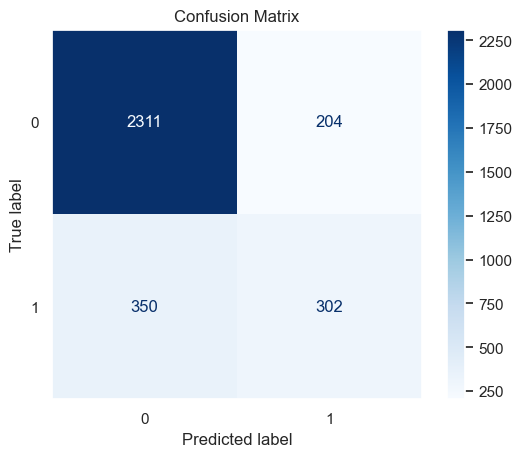

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      2515
         1.0       0.60      0.46      0.52       652

    accuracy                           0.83      3167
   macro avg       0.73      0.69      0.71      3167
weighted avg       0.81      0.83      0.82      3167

******************************************************************************************************************************************************
Logistic Regression Model bsl Evaluation, all


<Figure size 800x600 with 0 Axes>

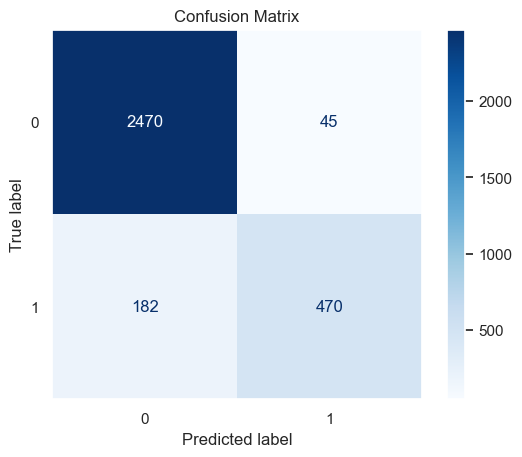

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      2515
         1.0       0.91      0.72      0.81       652

    accuracy                           0.93      3167
   macro avg       0.92      0.85      0.88      3167
weighted avg       0.93      0.93      0.93      3167



In [153]:
print('Logistic Regression Model bsl Evaluation')
evaluating(y_pred_rmf_nna_bsl,y_test_nna) 


print('*'*150)
print('Logistic Regression Model bsl Evaluation, all')
evaluating(y_pred_rmf_nna_all, y_test_nna) 

array([0.00191707, 0.00883903, 0.0765175 , 0.01470178, 0.02583299,
       0.02560276, 0.01601823, 0.01199056, 0.02072931, 0.01076723,
       0.01500927, 0.00414387, 0.00821981, 0.05090819, 0.23311361,
       0.06337544, 0.15173014, 0.19573423, 0.02750255, 0.03734642])

In [210]:
preprocessor = preprocessor_rmf_nna_all
cat_names = list(preprocessor.transformers_[0][1].named_steps['encoder'].get_feature_names_out(cat_col))
num_names = list(preprocessor.transformers_[1][1].named_steps['scaler'].get_feature_names_out(num_col))
feature_names = cat_names + num_names


# Feature importance
importance_df = pd.DataFrame({'names':feature_names, 'importance':list(model_rmf_nna_all.feature_importances_)})
importance_df.sort_values(by='importance',ascending=False)

,names,importance
14,customer_income,0.233114
17,loan_int_rate,0.195734
16,loan_amnt,0.151730
2,home_ownership_RENT,0.076517
15,employment_duration,0.063375
13,customer_age,0.050908
19,cred_hist_length,0.037346
18,term_years,0.027503
4,loan_intent_HOMEIMPROVEMENT,0.025833
5,loan_intent_MEDICAL,0.025603


In [212]:
corr_gini_df.sort_values(by='gini',ascending=False)

,name,gini
1,customer_income,0.365103
2,employment_duration,0.140473
0,customer_age,0.047529
6,cred_hist_length,0.034789
5,term_years,-0.040078
3,loan_amnt,-0.118115
4,loan_int_rate,-0.432170


loan grade -> less predictive than expected

customer_income, employment_duration, loan_int_rate, loan_amount, loan_intent, home_ownership

In [215]:
woe_table_na['home_ownership'].build() # WOE transformation in home ownership

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[OWN],2331,0.079551,2196,135,0.057915,1.458336,0.106033,0.012192
1,[MORTGAGE],12098,0.412873,10696,1402,0.115887,0.701188,0.163092,0.019979
2,"[OTHER, RENT]",14873,0.507576,10285,4588,0.308478,-0.523539,0.159838,0.019755
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,29302,1.000000,23177,6125,0.209030,,0.428963,0.051925


In [217]:
woe_table_na['loan_intent'].build() # No woe transformation

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[VENTURE],5143,0.175517,4431,712,0.138441,0.497521,0.037282,0.004613
1,[EDUCATION],5804,0.198075,4879,925,0.159373,0.33212,0.019758,0.002458
2,[PERSONAL],4963,0.169374,4043,920,0.185372,0.149587,0.003625,0.000453
3,[HOMEIMPROVEMENT],3244,0.110709,2449,795,0.245068,-0.205689,0.004963,0.000619
4,[MEDICAL],5460,0.186335,4103,1357,0.248535,-0.22434,0.009988,0.001246
5,[DEBTCONSOLIDATION],4688,0.159989,3272,1416,0.302048,-0.493216,0.044394,0.005494
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,29302,1.000000,23177,6125,0.209030,,0.120011,0.014883


## WOE Transformation in home_ownership

In [220]:
optb_ho = OptimalBinning(name='home_ownership',dtype='categorical')
optb_ho.fit(X_train_nna['home_ownership'], y_train_nna)
X_train_nna['home_ownership_woe'] =  optb_ho.transform(X_train_nna['home_ownership'], metric="woe")
X_test_nna['home_ownership_woe'] = optb_ho.transform(X_test_nna['home_ownership'])
optb_ho.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[OWN],2174,0.076291,2053,121,0.055658,1.494847,0.105496,0.012082
1,[MORTGAGE],11813,0.414549,10459,1354,0.114619,0.70798,0.166484,0.020387
2,"[RENT, OTHER]",14509,0.509159,10054,4455,0.307051,-0.522477,0.159735,0.019743
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,28496,1.000000,22566,5930,0.208099,,0.431715,0.052211


customer_income, employment_duration, loan_int_rate, loan_amount, loan_intent, home_ownership/home_ownership_woe

In [221]:
# Define numeric & categorical col
# not woe encoded
numeric_col_nna_2 = ['customer_income','loan_int_rate','employment_duration','loan_amnt']
categorical_col_nna_2 = ['loan_intent','home_ownership']

X_train_nna_2 = X_train_nna[categorical_col_nna_2+numeric_col_nna_2]
X_test_nna_2 = X_test_nna[categorical_col_nna_2+numeric_col_nna_2]
# woe encoded
numeric_col_nna_woe2 = ['customer_income','loan_int_rate','employment_duration','loan_amnt','home_ownership_woe']
categorical_col_nna_woe2 = ['loan_intent']

X_train_nna_woe2 = X_train_nna[categorical_col_nna_woe2+numeric_col_nna_woe2]
X_test_nna_woe2 = X_test_nna[categorical_col_nna_woe2+numeric_col_nna_woe2]

### Random Forest Regression

In [223]:
# Tuning
preprocessor_rmf_nna_2 = param_tuning(X_train_nna_2,y_train_nna, 
                                        RandomForestClassifier(),param_grid_rmf,
                                        cat_col=categorical_col_nna_2,num_col=numeric_col_nna_2)


# Tuning
preprocessor_rmf_nna_woe2 = param_tuning(X_train_nna_woe2,y_train_nna, 
                                        RandomForestClassifier(),param_grid_rmf,
                                        cat_col=categorical_col_nna_woe2,num_col=numeric_col_nna_woe2)

Best parameters found:  {'classifier__max_features': None, 'classifier__n_estimators': 150}
Best parameters found:  {'classifier__max_features': None, 'classifier__n_estimators': 200}


In [224]:
# Training & testing
# With no missing
model_rmf_nna_2 = RandomForestClassifier(
                        max_features=None, 
                        n_estimators = 150,
                                        )
y_pred_rmf_nna_2 = testing(X_train_nna_2,y_train_nna, X_test_nna_2,y_test_nna, model=model_rmf_nna_2, preprocessor=preprocessor_rmf_nna_2)

# With WOE
model_rmf_nna_woe2 = RandomForestClassifier(
                        max_features=None, 
                        n_estimators = 200,
                                        )
y_pred_rmf_nna_woe2 = testing(X_train_nna_woe2,y_train_nna, X_test_nna_woe2,y_test_nna, model=model_rmf_nna_woe2, preprocessor=preprocessor_rmf_nna_woe2)

Logistic Regression Model bsl Evaluation


<Figure size 800x600 with 0 Axes>

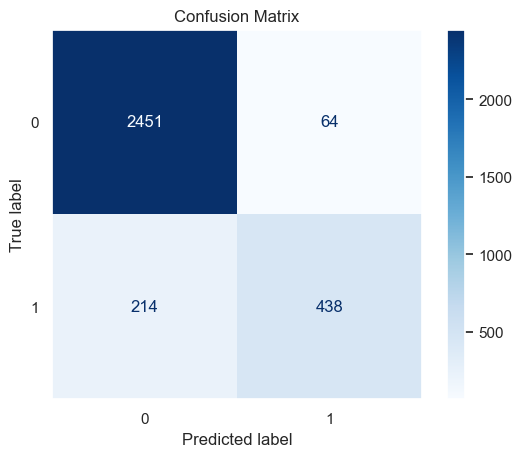

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95      2515
         1.0       0.87      0.67      0.76       652

    accuracy                           0.91      3167
   macro avg       0.90      0.82      0.85      3167
weighted avg       0.91      0.91      0.91      3167

******************************************************************************************************************************************************
Logistic Regression Model bsl Evaluation, all


<Figure size 800x600 with 0 Axes>

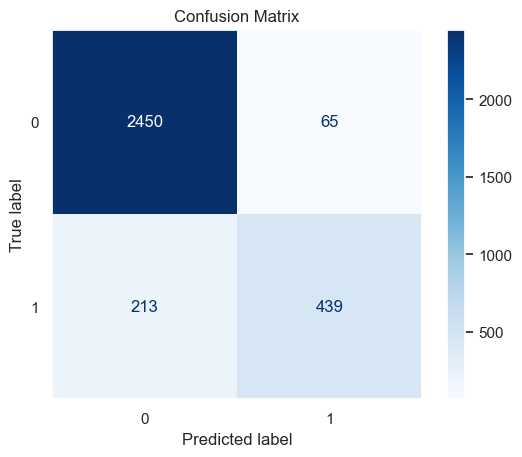

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95      2515
         1.0       0.87      0.67      0.76       652

    accuracy                           0.91      3167
   macro avg       0.90      0.82      0.85      3167
weighted avg       0.91      0.91      0.91      3167



In [225]:
print('Logistic Regression Model bsl Evaluation')
evaluating(y_pred_rmf_nna_2,y_test_nna) 


print('*'*150)
print('Logistic Regression Model bsl Evaluation, all')
evaluating(y_pred_rmf_nna_woe2, y_test_nna) 

NICEEEE, recall is still a weakness here, which is kinda bad. 

### KNN

In [226]:
# Define grid search parameters 6mins
# Tuning
preprocessor_knn_nna_2 = param_tuning(X_train_nna_2,y_train_nna, KNeighborsClassifier(),param_grid_knn,cat_col=categorical_col_nna_2,num_col=numeric_col_nna_2)

# With WOE
# Tuning
preprocessor_knn_nna_woe2 = param_tuning(X_train_nna_woe2,y_train_nna, KNeighborsClassifier(),param_grid_knn,cat_col=categorical_col_nna_woe2,num_col=numeric_col_nna_woe2)

Best parameters found:  {'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}
Best parameters found:  {'classifier__n_neighbors': 20, 'classifier__weights': 'distance'}


In [227]:
# Training & testing
# With no missing
model_knn_nna_2 = KNeighborsClassifier(
                        n_neighbors=15, 
                        weights = 'distance',
                                        )
y_pred_knn_nna_2 = testing(X_train_nna_2,y_train_nna, X_test_nna_2,y_test_nna, model=model_knn_nna_2, preprocessor=preprocessor_knn_nna_2)

# With WOE
model_knn_nna_woe2 = KNeighborsClassifier(
                        n_neighbors=20, 
                        weights = 'distance',
                                        )
y_pred_knn_nna_woe2 = testing(X_train_nna_woe2,y_train_nna, X_test_nna_woe2,y_test_nna, model=model_knn_nna_woe2, preprocessor=preprocessor_knn_nna_woe2)

Logistic Regression Model bsl Evaluation


<Figure size 800x600 with 0 Axes>

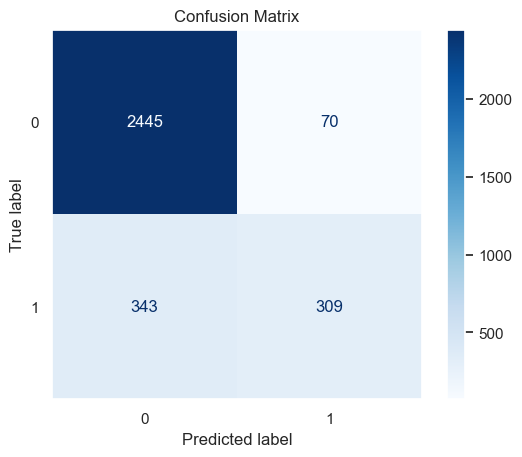

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      2515
         1.0       0.82      0.47      0.60       652

    accuracy                           0.87      3167
   macro avg       0.85      0.72      0.76      3167
weighted avg       0.86      0.87      0.86      3167

******************************************************************************************************************************************************
Logistic Regression Model bsl Evaluation, all


<Figure size 800x600 with 0 Axes>

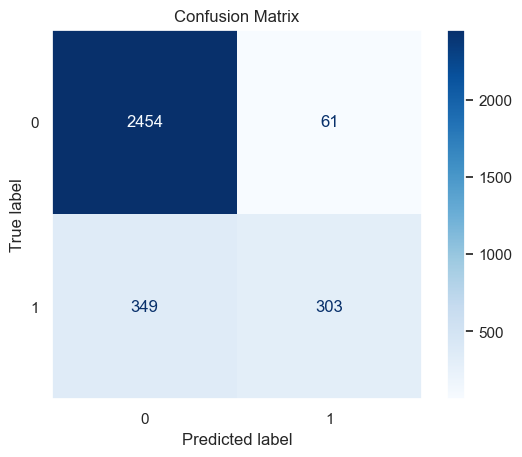

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.92      2515
         1.0       0.83      0.46      0.60       652

    accuracy                           0.87      3167
   macro avg       0.85      0.72      0.76      3167
weighted avg       0.87      0.87      0.86      3167



In [229]:
print('Logistic Regression Model bsl Evaluation')
evaluating(y_pred_knn_nna_2,y_test_nna) 


print('*'*150)
print('Logistic Regression Model bsl Evaluation, all')
evaluating(y_pred_knn_nna_woe2, y_test_nna) 

## Final Model
Random Forest with 'customer_income','loan_int_rate','employment_duration','loan_amnt', loan_intent and home_ownership

In [234]:
# # Export preprocessor 
# joblib.dump(preprocessor_rmf_nna_2,'preprocessor_final.pkl')

['preprocessor_final.pkl']

In [301]:
numeric_col_f = ['customer_income','loan_int_rate','employment_duration','loan_amnt']
categorical_col_f = ['loan_intent','home_ownership']
# X_f = risk_nna[numeric_col_f+categorical_col_f]
# y_f=risk_nna['Current_loan_status_encoded']

X_pr.loc[65478] = [29,6000, 'RENT', 2.0, 'PERSONAL','D',90000,11.2,9,'N',5] # To show 1 positive prediction
X_pr_final = X_pr[numeric_col_f+categorical_col_f].copy()
X_pr

,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length
21791,27,60000,RENT,6.0,PERSONAL,A,6000.0,8.94,7,N,9
22076,29,52000,MORTGAGE,6.0,VENTURE,D,12000.0,15.65,9,N,8
23069,29,60000,OWN,9.0,PERSONAL,C,9000.0,12.23,9,N,10
65478,29,6000,RENT,2.0,PERSONAL,D,90000.0,11.20,9,N,5


In [298]:
# Preprocessing
preprocessor_f = joblib.load('preprocessor_final.pkl')
# X_f_transformed = preprocessor_f.fit_transform(X_f)
X_pr_transformed = preprocessor_f.transform(X_pr_final)

In [242]:
# # Final Model Establishment
# model_f = RandomForestClassifier(
#                         max_features=None, 
#                         n_estimators = 150,
#                                         )

# model_f.fit(X_f_transformed, y_f)

# joblib.dump(model_f,'model_final.pkl')

['model_final.pkl']

In [299]:
model_f = joblib.load('model_final.pkl')
model_f.predict(X_pr_transformed)

array([0., 0., 0., 1.])

In [ ]:
# pip install category_encoders
# pip install optbinning
import category_encoders as ce
from optbinning import BinningProcess

(CVXPY) Aug 10 09:53:09 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 10 09:53:09 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
